In [71]:
import os
import tridy
from tridy import GeoConcept, SubGeoConcept, MetaData, Table, View, DBStorage, DataSource, Feature, FeatureWithID,  AdmUnitFeature, OLUFeature, Grid, Imagee, ds_from_metadata, xml_lpis_cz_reader, lpis_cz__posledni_aktualizace, get_listvalues_from_generator, apply_function, select_nodes_from_graph, unzip_file, find_neighbors_till, connection_parameters_to_pg, world_to_pixel 
from importlib import reload
import requests
import datetime
import re

In [2]:
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

from osgeo import ogr, osr, gdal
import numpy as np
import json

from ipyleaflet import Map, GeoJSON, Marker
from ipywidgets import HTML

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from pygeoprocessing import routing

import tempfile
from tempfile import TemporaryDirectory

In [73]:
def compilable_node_dictionary(object,node__level=0,node__name='1'): 
    g_dict=\
    {'admunit':{'object':object},\
    'admunit__tree':{'object':'admunit','function':'return_graph_representation'},\
    'admunit__tree__reverse':{'object':'admunit__tree','function':'reverse'},\
    'node__level':{'object':node__level},\
    'node__name':{'object':node__name},\
    'admunit__tree__level':{'function':select_nodes_from_graph,'parameters':['admunit__tree','level','node__level']},\
    'admunit__tree__neighbors':{'function':find_neighbors_level,'parameters':['admunit__tree','node__name','node__level']},\
    'admunit__tree__neighbors__3201__4':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','3201',4]},\
    'admunit__tree__neighbors__3201__3':{'function':find_neighbors_level,'parameters':['admunit__tree__reverse','3201',3]},\
    }
    return g_dict

In [74]:
def find_neighbors_level(graph,start_node,level):
    if graph.nodes()[start_node]['level']==level:
        yield start_node
    else:
        for n in graph.neighbors(start_node):
            yield from find_neighbors_level(graph,n,level) 

In [75]:
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('http://', HTTPAdapter(max_retries=retries))

In [76]:
replacement_dictionary = {"[posledni_den_mesice]":(datetime.datetime.today().replace(day=1)-datetime.timedelta(days=1)).strftime('%Y%m%d'),"[lpis_cz__posledni_aktualizace]":lpis_cz__posledni_aktualizace().strftime('%Y%m%d'), "[vcera]":(datetime.datetime.today().replace(day=1)-datetime.timedelta(days=1)).strftime('%Y%m%d')} 

In [77]:
json_feature_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_feature_with_bigid_structure=[{"name":"id","type":"bigint primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"}]
json_admin_unit_structure=[{"name":"id","type":"integer primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"level","type":"integer"},{"name":"parent_id","type":"text"}]
json_admin_unit_structure_at=[{"name":"id","type":"text primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"level","type":"integer"},{"name":"parent_id","type":"text"}]
json_feature_with_raster_structure=[{"name":"id","type":"serial primary key"},{"name":"geom","type":"geometry"},{"name":"data","type":"json"},{"name":"raster_maps","type":"raster"}]

In [78]:
admunit_cz__metadata=MetaData('Uzemni celky v CR',
                              {"url":"https://vdp.cuzk.cz/vymenny_format/soucasna/[posledni_den_mesice]_ST_UKSG.xml.zip",
                               "format":"GML", "compression":"zip"},'data')

In [79]:
admunit_cz__ds=ds_from_metadata(admunit_cz__metadata)

In [80]:
admunit_cz=GeoConcept('Uzemni celky v CR','Uzemni celky v CR. Vsechny urovne.',
                      'AdmUnitFeature',json_admin_unit_structure, data_source=admunit_cz__ds, subgeoconcepts=[] )

In [81]:
url_adresa=admunit_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])

In [82]:
admunit_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [83]:
#admunit_cz.get_data_source().download_data('archive.zip',s,'all',(os.getcwd()+'/'))
admunit_cz.get_data_source().set_data_file('20210131_ST_UKSG.xml')

In [84]:
concept_list=['Staty','Vusc','Okresy','Obce','KatastralniUzemi']

In [85]:
concept_additional_attributes={'Staty':{'level_value':0,'parent_value':'null','id_attribute':'Kod'},
                               'Vusc':{'level_value':1,'parent_value':'1','id_attribute':'Kod'},
                               'Okresy':{'level_value':2,'parent_attribute':'VuscKod','id_attribute':'Kod'},
                               'Obce':{'level_value':3,'parent_attribute':'OkresKod','id_attribute':'Kod'},
                               'KatastralniUzemi':{'level_value':4,'parent_attribute':'ObecKod','id_attribute':'Kod'}}

In [86]:
for l in list(set(concept_list).intersection(set(admunit_cz.get_data_source().list_layers()))):
    admunit_cz.append_subgeoconcept(SubGeoConcept(l,l,'AdmUnitFeature',admunit_cz.get_attributes(),data_source=DataSource(admunit_cz.get_data_source().get_type(),admunit_cz.get_data_source().get_name(),({**admunit_cz.get_data_source().get_attributes(),**{'layer':l}}),None,admunit_cz.get_data_source().get_data_file()),supergeoconcept=admunit_cz,table_inheritance=False,type='semantic',subgeoconcepts=[]))

In [87]:
wgs84_sr=osr.SpatialReference()
wgs84_sr.ImportFromProj4('+proj=longlat +datum=WGS84 +no_defs')

sjtsk5514_sr=osr.SpatialReference()
sjtsk5514_sr.ImportFromProj4('+proj=krovak +lat_0=49.5 +lon_0=24.83333333333333 +alpha=30.28813975277778 +k=0.9999 +x_0=0 +y_0=0 +ellps=bessel +units=m +towgs84=570.8,85.7,462.8,4.998,1.587,5.261,3.56 +no_defs')

sjtsk5514_to_wgs84=osr.CoordinateTransformation(sjtsk5514_sr,wgs84_sr)

In [134]:
for sub in admunit_cz.get_subgeoconcepts():
    sub.set_geojson_output_backend(os.getcwd()+'/',sub.get_name()+'.geojson')
    #with open(sub.get_geojson_output_backend(), 'w', encoding='utf-8') as file:
    #    geojson={"type": "FeatureCollection", "features": [] }
    #    features=sub.get_data_source().read_features('admunitfeature',concept_additional_attributes[sub.get_data_source().get_attributes()['layer']],number=10)
    #    for f in features:
    #            if len(f)>0:
    #                for feature in f:
    #                    feature.transform_geometry(sjtsk5514_to_wgs84)
    #                    geojson["features"].append(feature.export_to_geojson())
    #    json.dump(geojson, file, ensure_ascii=False, indent=4)

In [89]:
admunit_cz.get_subgeoconcept_by_name('Okresy').get_geojson_output_backend()

'/home/jupyter-dima/Okresy.geojson'

In [90]:
m=Map(center=(49.98,14.73),zoom=10)

In [91]:
with open(admunit_cz.get_subgeoconcept_by_name('Okresy').get_geojson_output_backend(),'r', encoding='utf-8') as f:
    data = json.load(f)

In [92]:
features = data['features']
for i in range(len(features)):
    location=(features[i]['geometry']['coordinates'][1],features[i]['geometry']['coordinates'][0])
    nazvy = features[i]['properties']['Nazev']
    id = features[i]['properties']['gml_id']
    html = """
    <p>
      <h4><b>Okres</b>:        """ + " ".join(nazvy) + """</h4>
    </p>
    <p>
      <h5><b>ID</b>:        """ + " ".join(id) + """</h5>
    </p>
    """
    marker = Marker(location=location)
    # Popup associated to a layer
    marker.popup = HTML(html)
    m.add_layer(marker)

In [93]:
display(m)

Map(center=[49.98, 14.73], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [94]:
G=apply_function(compilable_node_dictionary(admunit_cz),'admunit__tree')

In [95]:
list(find_neighbors_level(G.reverse(),'3201',4))

['600466',
 '778796',
 '638587',
 '651885',
 '784435',
 '784451',
 '784486',
 '792578',
 '793124',
 '668974',
 '668966',
 '751375',
 '762415',
 '762423',
 '762431',
 '767727',
 '778061',
 '739910',
 '607932',
 '602655',
 '767140',
 '652709',
 '716308',
 '625426',
 '633836',
 '651168',
 '653969',
 '651273',
 '607801',
 '659134',
 '685330',
 '787043',
 '788431',
 '615820',
 '703788',
 '737054',
 '737038',
 '737071',
 '744972',
 '744930',
 '645133',
 '701131',
 '701157',
 '674427',
 '675547',
 '789631',
 '613495',
 '702919',
 '686492',
 '786993',
 '787019',
 '702927',
 '702935',
 '792331',
 '691976',
 '762105',
 '790133',
 '704121',
 '704148',
 '704105',
 '704113',
 '704130',
 '736431',
 '737267',
 '737216',
 '750981',
 '750956',
 '757055',
 '608106',
 '757063',
 '757071',
 '608084',
 '608092',
 '608114',
 '758469',
 '765295',
 '703168',
 '621161',
 '621153',
 '623156',
 '624331',
 '792187',
 '679607',
 '692727',
 '624624',
 '626261',
 '679593',
 '735191',
 '738549',
 '751537',
 '751553',

In [96]:
lpis_cz__metadata=MetaData('LPIS v okrese Benesov',
                              [{"url":"http://eagri.cz/public/app/eagriapp/lpisdata/[lpis_cz__posledni_aktualizace]-{admunit__tree__neighbors__3201__4}-DPB-SHP.zip",
                               "format":"SHP", "compression":"zip"},{"url":"http://eagri.cz/public/app/eagriapp/lpisdata/[lpis_cz__posledni_aktualizace]-{admunit__tree__neighbors__3201__4}-DPB-XML-A.zip",
                               "format":"XML", "compression":"zip"}],'data')
lpis_cz__ds_xml=ds_from_metadata(lpis_cz__metadata,format='XML')
lpis_cz=GeoConcept('LPIS v okrese Benesov','LPIS v okrese Benesov. Data ze vsech katastralnich uzemi v okrese.',
                      'Feature',json_feature_structure, data_source=lpis_cz__ds_xml, subgeoconcepts=[], adm_graph_node='3201')

In [97]:
url_adresa=lpis_cz.get_data_source().get_attributes()['url']
for i in re.findall('\[.*?\]',url_adresa):
    if i in list(replacement_dictionary.keys()):
        url_adresa=url_adresa.replace(i,replacement_dictionary[i])
lpis_cz.get_data_source().set_attribute({'url':url_adresa})
del(url_adresa)

In [98]:
for i in re.findall('\{.*?\}',lpis_cz.get_data_source().get_attributes()['url']): 
    if i[1:-1] in list(compilable_node_dictionary(admunit_cz).keys()):
        for j in apply_function(compilable_node_dictionary(admunit_cz),i[1:-1]):
                lpis_cz.append_subgeoconcept(SubGeoConcept(str(j),'LPIS in Czech administrative territorial unit %s ' % str(j),'Feature',lpis_cz.get_attributes(),data_source=DataSource(lpis_cz.get_data_source().get_type(),lpis_cz.get_data_source().get_name(),(dict(lpis_cz.get_data_source().get_attributes(),**{'url':lpis_cz.get_data_source().get_attributes()['url'].replace(i,str(j))})),None,None),supergeoconcept=lpis_cz,table_inheritance=True,subgeoconcepts=[],type='spatial:admin',adm_graph_node=str(j)))

In [30]:
len(lpis_cz.get_subgeoconcepts())

271

In [99]:
for sub in lpis_cz.get_subgeoconcepts():
    sub.set_geojson_output_backend(os.getcwd()+'/',sub.get_name()+'.geojson')
    #sub.get_data_source().download_data('archive.zip',s,'all',(os.getcwd()+'/'))
    #with open(sub.get_geojson_output_backend(), 'w', encoding='utf-8') as file:
    #    geojson={"type": "FeatureCollection", "features": [] }
    #    features=sub.get_data_source().read_features('feature',number=10,reader=xml_lpis_cz_reader)
    #    for f in features:
    #            if len(f)>0:
    #                for feature in f:
    #                    feature.transform_geometry(sjtsk5514_to_wgs84)
    #                    geojson["features"].append(feature.export_to_geojson())
    #    json.dump(geojson, file, ensure_ascii=False, indent=4)
    #os.remove(sub.get_data_source().get_data_file())

In [100]:
features_gen=lpis_cz.read_features_from_geojson_output_backend('feature',number=1)
feature_gen=next(features_gen)
feature=next(feature_gen)[0]
feature.get_data()

{'IDDPB': '10168932',
 'CTVEREC': '730-1090',
 'ZKOD': '5601/1',
 'STAV': 'UCINNY',
 'STAVID': '4',
 'UCINNOST_DLE_ZAKONA': '2007/10/04',
 'PLATNOSTOD': '2015/01/02',
 'VYMERA': '2.08',
 'VYMERAOPV': '0',
 'KULTURA': 'L',
 'KULTURAID': '99',
 'KULTURANAZEV': 'zalesněná půda',
 'KULTURAOD': '2007/10/04',
 'UZIVATEL': '{ "IDUZIVATELE": "86777", "JMENO": "JANA", "PRIJMENI": "PĚNKAVOVÁ", "OBCHODNIJMENO": "PĚNKAVOVÁ JANA", "PRAVNIFORMA": "100" }',
 'ZAKLADNI': '[ { "KOD": "OLDIDDPB", "HODNOTAINT": "28333440", "PLATNOSTOD": "2016-08-01" }, { "KOD": "OLDIDDPB", "HODNOTAINT": "20230482", "PLATNOSTOD": "2016-01-01", "PLATNOSTDO": "2016-07-31" }, { "KOD": "OLDIDDPB", "HODNOTAINT": "12940476", "PLATNOSTOD": "2015-01-02", "PLATNOSTDO": "2015-12-31" }, { "KOD": "EKO", "HODNOTAINT": "0", "PLATNOSTOD": "2015-01-02" }, { "KOD": "NADMVYSKA", "HODNOTANUM": "573.3", "PLATNOSTOD": "2005-01-01", "PLATNOSTDO": "2015-12-31" }, { "KOD": "SKLONITOST", "HODNOTANUM": "4.3", "PLATNOSTOD": "2005-01-01", "PLATNOSTD

In [101]:
with open(lpis_cz.get_subgeoconcept_by_name('602191').get_geojson_output_backend(),'r', encoding='utf-8') as f:
    data = json.load(f)

In [102]:
geo_json = GeoJSON(data=data, style = {'color': 'green'})
m.add_layer(geo_json)

In [103]:
display(m)

Map(center=[49.98, 14.73], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [104]:
for feature in data['features']:
    if feature['properties']['KULTURAID']!='99':
        data['features'].remove(feature)

In [105]:
geo_json = GeoJSON(data=data, style = {'color': 'red'})
m.add_layer(geo_json)

In [106]:
display(m)

Map(center=[49.98, 14.73], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [107]:
def get_twi(im_object):
    with TemporaryDirectory() as tempdir:
        im_object.export_as_tif('%s/dem.tif' %tempdir)
        routing.fill_pits(('%s/dem.tif' %tempdir,1),'%s/cdem.tif' %tempdir)
        routing.flow_dir_mfd(('%s/cdem.tif' %tempdir,1),'%s/dir.tif' %tempdir)
        routing.flow_accumulation_mfd(('%s/dir.tif' %tempdir,1),'%s/twi.tif' %tempdir)
        ds = gdal.Open('%s/twi.tif' %tempdir)
        metadata_dict=im_object.get_metadata()
        twi=Imagee(np.array(ds.GetRasterBand(1).ReadAsArray()),metadata_dict)
        return twi

In [108]:
features_gen=lpis_cz.read_features_from_geojson_output_backend('feature',number=1)
feature_gen=next(features_gen)
feature=next(feature_gen)[0]
feature.get_geometry()

'POLYGON ((14.6236764807982 49.6190885859837,14.6236891386128 49.6189535961369,14.6239668163448 49.6189479832856,14.6241909085313 49.6189785046547,14.624551312021 49.6190318556488,14.6247380642339 49.6190336994905,14.6248644664943 49.6190302560092,14.6249706647743 49.6190232277682,14.6250700008043 49.6194193572823,14.6250897873756 49.6195662624297,14.6251376531977 49.6197528276436,14.6251588736061 49.619872638649,14.6252132433554 49.6200951591406,14.6252270663047 49.6202506150047,14.6252295583613 49.6202824864715,14.625232060173 49.6203348260037,14.6252361607551 49.6203669257564,14.6252423531573 49.6204461213171,14.6252514117163 49.6204863113841,14.6252577839628 49.620588731633,14.6252794312538 49.6207923375155,14.6253001275672 49.6210627181302,14.6253232749902 49.6212607275855,14.6251033566508 49.621288254991,14.6248200891747 49.6213203603241,14.6246807538667 49.6213471073439,14.6244403577788 49.6213966033175,14.6244206931601 49.6213567729542,14.6244373233585 49.6213237515307,14.62444

In [109]:
dem30_fn='eu_dem_czat3035.tif'
dem30=gdal.Open(dem30_fn)

In [110]:
etrs3035_sr=osr.SpatialReference()

etrs3035_sr.ImportFromProj4('+proj=laea +lat_0=52 +lon_0=10 +x_0=4321000 +y_0=3210000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs')

wgs_84_to_etrs3035=osr.CoordinateTransformation(wgs84_sr,etrs3035_sr)

In [111]:
metadata_dict={}
metadata_dict['affine_transformation']=dem30.GetGeoTransform()
metadata_dict['nodata']=dem30.GetRasterBand(1).GetNoDataValue()
metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [114]:
grid=Grid((metadata_dict['affine_transformation'][0],metadata_dict['affine_transformation'][3]),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [115]:
feature_geometry=ogr.CreateGeometryFromWkt(feature.get_geometry())

In [116]:
feature_geometry.Transform(wgs_84_to_etrs3035)

0

In [117]:
feature_geometry.ExportToWkt()

'POLYGON ((4654913.17792336 2955658.70729269,4654915.02067501 2955643.7779468,4654935.08230379 2955644.41683354,4654951.03097824 2955648.82393094,4654976.65151563 2955656.38528923,4654990.10522029 2955657.43892894,4654999.24361834 2955657.63124122,4655006.94984353 2955657.33373229,4655011.38284189 2955701.76446836,4655011.79718973 2955718.16414424,4655013.96292194 2955739.09461964,4655014.66735819 2955752.49276605,4655017.05422331 2955777.44464489,4655016.97956501 2955794.76653102,4655016.93960321 2955798.31629923,4655016.75928014 2955804.13852045,4655016.83372926 2955807.72094629,4655016.73442962 2955816.54156005,4655017.11062022 2955821.0447303,4655016.86422072 2955832.44461691,4655017.02186564 2955855.14779568,4655016.65070691 2955885.26012778,4655016.95505485 2955907.34880169,4655000.90811164 2955909.40517205,4654980.2618436 2955911.68187042,4654970.03074916 2955914.0180084,4654952.3559214 2955918.42044081,4654951.21246823 2955913.90900126,4654952.63913319 2955910.31847916,4654953.

In [118]:
feature_geometry_buffer=feature_geometry.Buffer(500)

In [119]:
origin=tuple(grid.find_index((feature_geometry_buffer.GetEnvelope()[0],feature_geometry_buffer.GetEnvelope()[3])))
size=tuple(np.array(grid.find_index((feature_geometry_buffer.GetEnvelope()[1],feature_geometry_buffer.GetEnvelope()[2])))-np.array(grid.find_index((feature_geometry_buffer.GetEnvelope()[0],feature_geometry_buffer.GetEnvelope()[3]))))+np.array([1,1])
a=np.array(dem30.GetRasterBand(1).ReadAsArray(xoff=int(origin[0]),yoff=int(origin[1]),win_xsize=int(size[0]),win_ysize=int(size[1])))
grid_clip=Grid(np.array(grid.get_gridorigin())+np.array(tuple(grid.find_index((feature_geometry_buffer.GetEnvelope()[0],feature_geometry_buffer.GetEnvelope()[3]))))*np.array(grid.get_gridstepsize()),(metadata_dict['affine_transformation'][1],metadata_dict['affine_transformation'][5]))

In [120]:
clip_metadata_dict={}
clip_metadata_dict['affine_transformation']=grid_clip.get_affinetransformation()
clip_metadata_dict['nodata']=float(np.min(a)) if np.min(a)<0 else np.nan
clip_metadata_dict['proj_wkt']=etrs3035_sr.ExportToWkt()

In [121]:
im=Imagee(a,clip_metadata_dict)

In [122]:
im.export_as_tif('pole_s_bufrem500.tif')

In [123]:
im_twi=get_twi(im)

In [124]:
im_twi.export_as_tif('akumulace_vody_na_poli_s_bufrem500.tif')

In [125]:
cropped_im=Imagee(*im.clip_by_shape(feature_geometry.ExportToWkt()))

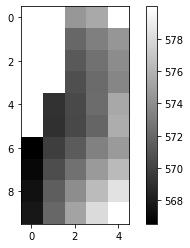

In [126]:
plt.imshow(cropped_im.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [127]:
cropped_im.get_statistics()

{'mean': 572.7201631986178, 'max': 579.9984130859375, 'min': 566.550537109375}

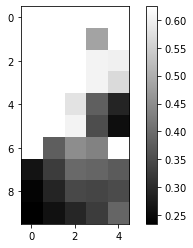

In [128]:
plt.imshow(Imagee(*cropped_im.calculate_slope()).get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

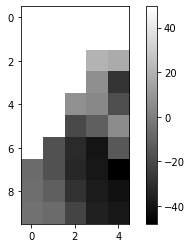

In [129]:
plt.imshow(Imagee(*cropped_im.calculate_azimuth()).get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [130]:
cropped_im__twi=Imagee(*im_twi.clip_by_shape(feature_geometry.ExportToWkt()))

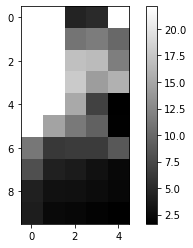

In [131]:
plt.imshow(cropped_im__twi.get_data(), origin="upper", cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [132]:
cropped_im__twi.get_statistics()

{'mean': 7.859872082943025,
 'max': 22.128263271521707,
 'min': 1.6344025121803198}

In [133]:
cropped_im__twi.export_as_tif('akumulace_vody_na_poli.tif')